# Confounds illustrated with Ordinary Least Squares (OLS)

In this notebook I go through three examples of confounds given by McElreath. In all three, we have two independent variables and we look at the expected out of sample performance, using the Aikake information criteria (AIC), when either variables is used to regress or when both are used. The first is a masked association, where it really helps to regress with two variables. The second shows the effect of colinear variables that when used together, yield a worse model than when one chooses one of them. Last, is a spurious correlation, where the regressing with two variables hurts, but just a little.

McElreath talks about four fundamental confounds: i) the fork, ii) the pipe, iii) the colider, and iv) the descendant. The third example, the spurious variable, is an example of the fork. I think that the second example, when it hurts to add a second variable is a colider. I'm very uncertain about the first example. 

In [1]:
from scipy import stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf 

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
milk = pd.read_csv('data/milk.csv', sep=';').dropna()
milk['log_mass'] = milk['mass'].apply(np.log)
milk.columns = [i.replace('.', '_') for i in milk.columns]
print(milk.shape)

(17, 9)


## 1. Masked association (when adding a variable helps)
This is an example where regression on either of two independent variables yields a regression result suggesting a modest effect on the dependent variable, but including both reveals stronger coefficients in opposite directions.

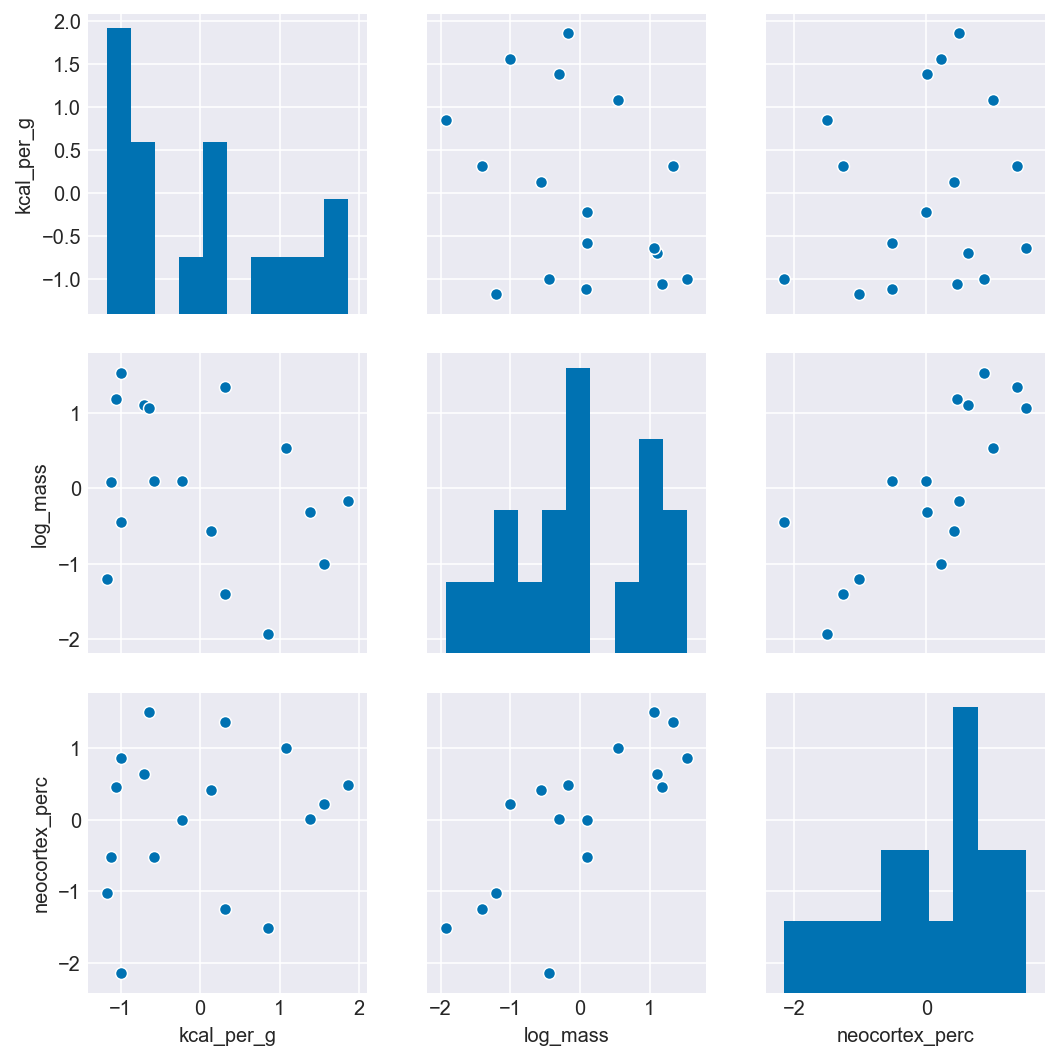

In [3]:
# Selecting columns and standarizing
masked = milk[['kcal_per_g', 'log_mass', 'neocortex_perc']].apply(ss.zscore)
sns.pairplot(masked);

OLS shows the predicting the milk's energ content (kcal_per_g) using the log-body-mass or percent-neocortx alone results in a regression coefficient confidence intervals that include zero. When the regression includes both independent variables the confidence intervals of both coefficientes exclude zero. The AIC suggest that the model with both predictors would have a better out of sample performance.

Note that in all three models, the intercept coeffcient is predicted to be very close to zero with slightly smaller confidence intervals for the model that used both predictors.

In [4]:
ols_masked_mass = smf.ols('kcal_per_g ~ log_mass', data=masked).fit()
ols_masked_neo = smf.ols('kcal_per_g ~ neocortex_perc', data=masked).fit()
ols_masked = smf.ols('kcal_per_g ~ log_mass + neocortex_perc', data=masked).fit()

In [5]:
pd.concat([
    ols_masked_mass.summary2().tables[1],
    ols_masked_neo.summary2().tables[1],
    ols_masked.summary2().tables[1]
], keys=['mass', 'neo', 'both']).T

/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


mass                     neo                         both  \
             Intercept  log_mass     Intercept neocortex_perc     Intercept   
Coef.     2.775558e-16 -0.354264  2.775558e-16       0.155458  2.775558e-16   
Std.Err.  2.414536e-01  0.241454  2.550599e-01       0.255060  1.828927e-01   
t         1.149520e-15 -1.467212  1.088199e-15       0.609494  1.517588e-15   
P>|t|     1.000000e+00  0.162971  1.000000e+00       0.551318  1.000000e+00   
[0.025   -5.146461e-01 -0.868910 -5.436472e-01      -0.388190 -3.922658e-01   
0.975]    5.146461e-01  0.160382  5.436472e-01       0.699105  3.922658e-01   

                                   
          log_mass neocortex_perc  
Coef.    -1.077767       0.964187  
Std.Err.  0.276686       0.276686  
t        -3.895268       3.484770  
P>|t|     0.001617       0.003644  
[0.025   -1.671199       0.370755  
0.975]   -0.484334       1.557620

In [6]:
pd.DataFrame([ols_masked_mass.aic, ols_masked_neo.aic, ols_masked.aic], index=['mass', 'neo', 'both'], columns=['AIC'])

,AIC
mass,49.964107
neo,51.828024
both,41.346792


In [7]:
ols_pred = ols_masked.get_prediction(exog=masked[['log_mass', 'neocortex_perc']]).predicted_mean
ols_ci = ols_masked.get_prediction(exog=masked[['log_mass', 'neocortex_perc']]).conf_int()
ols_err = abs(ols_ci[:, 0] - ols_pred)

ols_pred_m = ols_masked_mass.get_prediction(exog=masked[['log_mass']]).predicted_mean
ols_ci_m = ols_masked_mass.get_prediction(exog=masked[['log_mass']]).conf_int()
ols_err_m = abs(ols_ci_m[:, 0] - ols_pred_m)

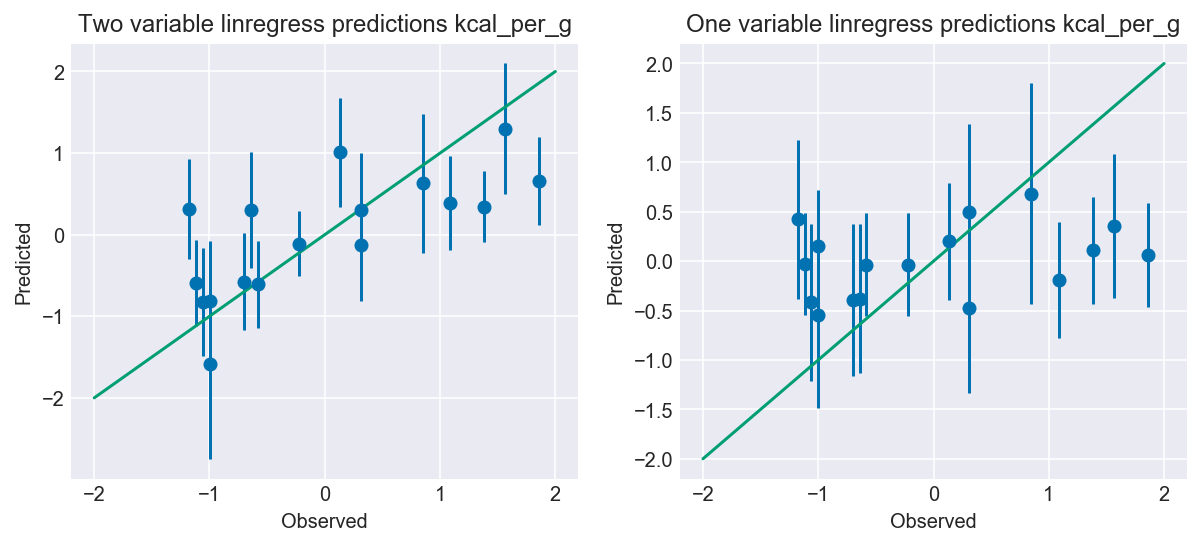

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].errorbar(masked['kcal_per_g'], ols_pred, yerr=ols_err, fmt='o')
ax[0].plot([-2, 2], [-2, 2])
ax[0].set_ylabel('Predicted')
ax[0].set_xlabel('Observed')
ax[0].set_title('Two variable linregress predictions kcal_per_g')

ax[1].errorbar(masked['kcal_per_g'], ols_pred_m, yerr=ols_err_m, fmt='o')
ax[1].plot([-2, 2], [-2, 2])
ax[1].set_ylabel('Predicted')
ax[1].set_xlabel('Observed')
ax[1].set_title('One variable linregress predictions kcal_per_g');

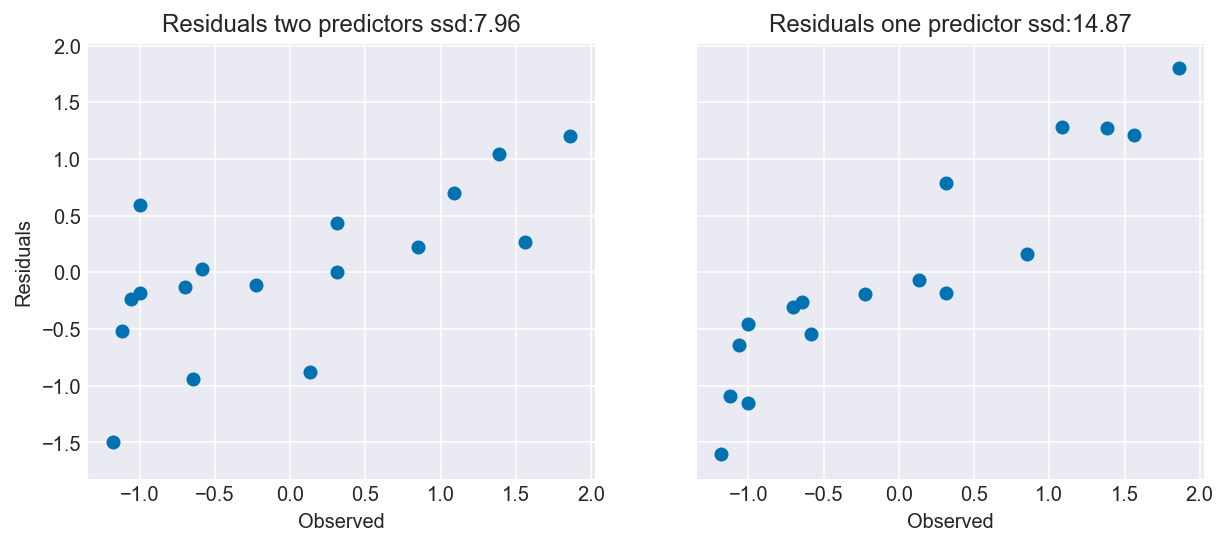

In [9]:
resid = masked['kcal_per_g'] - ols_pred
resid_m = masked['kcal_per_g'] - ols_pred_m

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
ax[0].scatter(masked['kcal_per_g'], resid)
ax[0].set_title('Residuals two predictors ssd:{0:.2f}'.format((resid**2).sum()))
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Observed')
ax[1].scatter(masked['kcal_per_g'], resid_m)
ax[1].set_title('Residuals one predictor ssd:{0:.2f}'.format((resid_m**2).sum()))
ax[1].set_xlabel('Observed');

## 2. Colinearity (when adding a variable hurts)

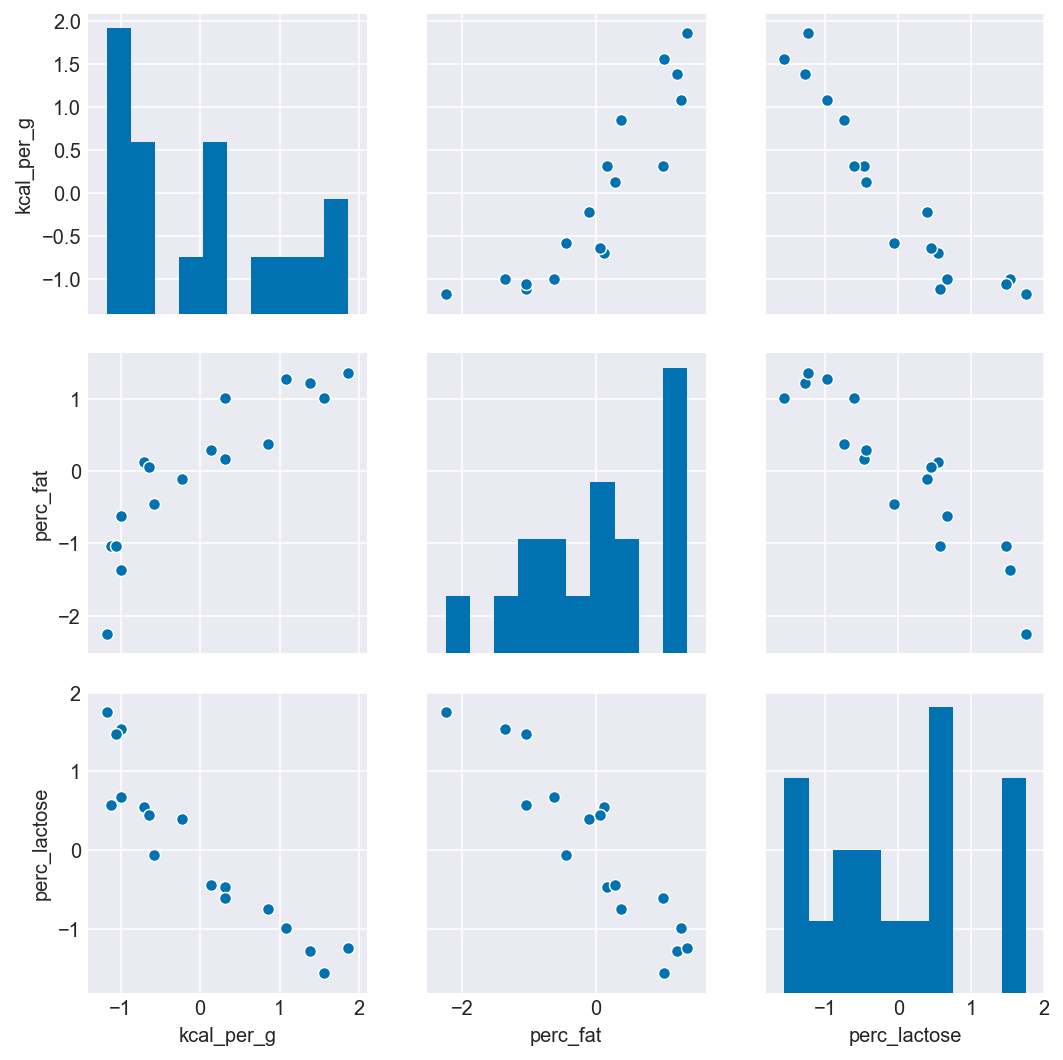

In [10]:
# Selecting columns and standarizing
colin = milk[['kcal_per_g', 'perc_fat', 'perc_lactose']].apply(ss.zscore)
sns.pairplot(colin);

In [11]:
ols_colin_fat = smf.ols('kcal_per_g ~ perc_fat', data=colin).fit()
ols_colin_lac = smf.ols('kcal_per_g ~ perc_lactose', data=colin).fit()
ols_colin_both = smf.ols('kcal_per_g ~ perc_fat + perc_lactose', data=colin).fit()

In [12]:
pd.concat([
    ols_colin_fat.summary2().tables[1],
    ols_colin_lac.summary2().tables[1],
    ols_colin_both.summary2().tables[1]
], keys=['fat', 'lac', 'both']).T

/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/sr/anaconda3/envs/main/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


fat                     lac                        both  \
             Intercept  perc_fat     Intercept  perc_lactose     Intercept   
Coef.     2.775558e-16  0.882278  2.775558e-16 -9.313042e-01  2.775558e-16   
Std.Err.  1.215416e-01  0.121542  9.404695e-02  9.404695e-02  9.621374e-02   
t         2.283628e-15  7.259063  2.951247e-15 -9.902546e+00  2.884783e-15   
P>|t|     1.000000e+00  0.000003  1.000000e+00  5.683180e-08  1.000000e+00   
[0.025   -2.590598e-01  0.623218 -2.004563e-01 -1.131761e+00 -2.063579e-01   
0.975]    2.590598e-01  1.141338  2.004563e-01 -7.308479e-01  2.063579e-01   

                                 
          perc_fat perc_lactose  
Coef.     0.145616    -0.796654  
Std.Err.  0.252723     0.252723  
t         0.576186    -3.152276  
P>|t|     0.573636     0.007060  
[0.025   -0.396422    -1.338692  
0.975]    0.687654    -0.254616

In [13]:
pd.DataFrame([
    ols_colin_fat.aic,
    ols_colin_lac.aic,
    ols_colin_both.aic
], index=['fat', 'lac', 'both'], columns=['AIC'])

,AIC
fat,26.625806
lac,17.906084
both,19.507658


In [14]:
# np.linalg.svd(milk[['perc_fat', 'perc_lactose', 'perc_protein', 'kcal_per_g', 'log_mass', 'neocortex_perc']])[1]
np.linalg.svd(milk[['kcal_per_g', 'log_mass', 'neocortex_perc']])[1]

array([279.73585461,   7.33990301,   0.54211827])

## 3. Spurious association

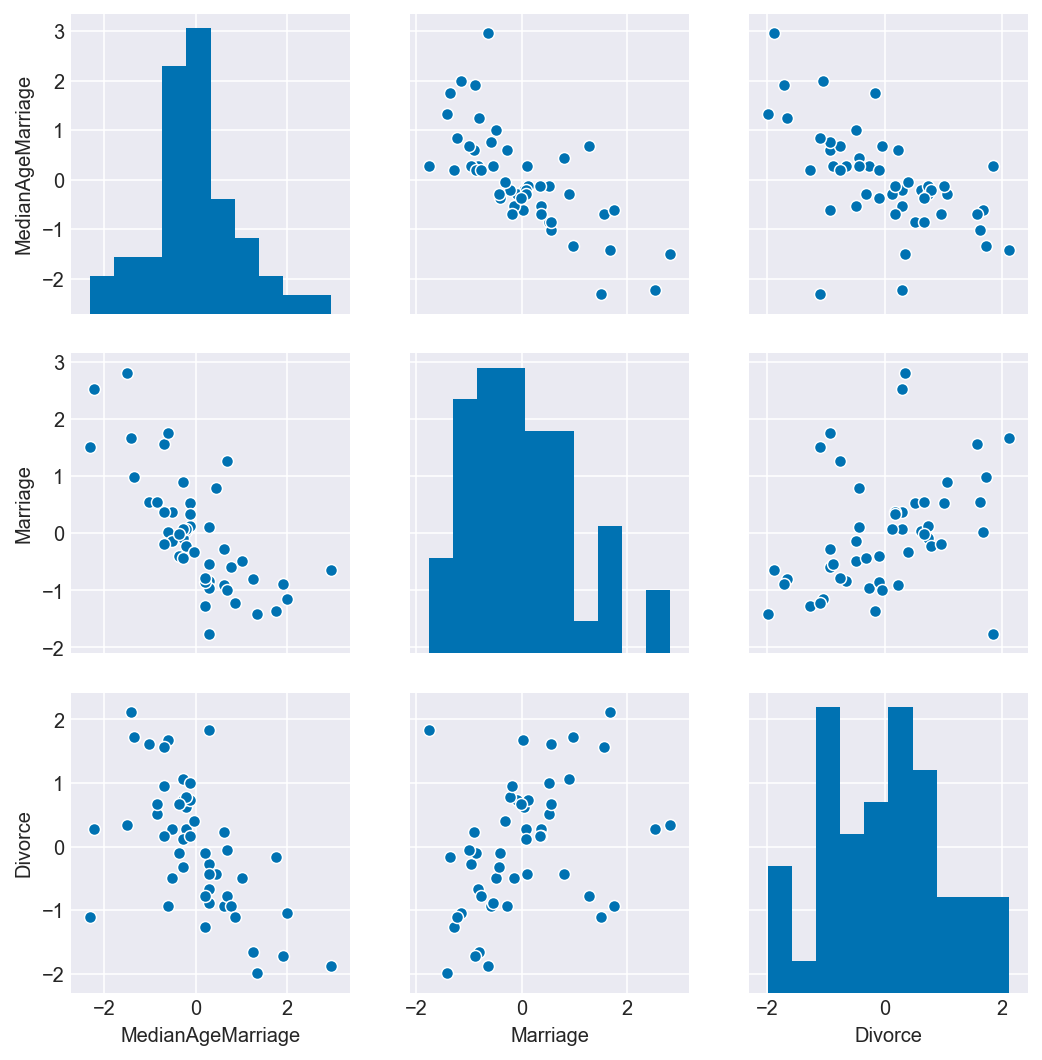

In [15]:
divorce = pd.read_csv('data/WaffleDivorce.csv', sep=';')[['MedianAgeMarriage', 'Marriage', 'Divorce']]\
    .apply(ss.zscore)
sns.pairplot(divorce);

In [16]:
ols_div_age = smf.ols('Divorce ~ MedianAgeMarriage', data=divorce).fit()
ols_div_mar = smf.ols('Divorce ~ Marriage', data=divorce).fit()
ols_div_both = smf.ols('Divorce ~ MedianAgeMarriage + Marriage', data=divorce).fit()

In [17]:
pd.concat([
    ols_div_age.summary2().tables[1],
    ols_div_mar.summary2().tables[1],
    ols_div_both.summary2().tables[1]
], keys=['age', 'marriage', 'both']).T

age                        marriage            \
             Intercept MedianAgeMarriage     Intercept  Marriage   
Coef.    -3.486794e-16         -0.597239 -3.486794e-16  0.373731   
Std.Err.  1.157678e-01          0.115768  1.338784e-01  0.133878   
t        -3.011885e-15         -5.158938 -2.604448e-15  2.791573   
P>|t|     1.000000e+00          0.000005  1.000000e+00  0.007507   
[0.025   -2.327669e-01         -0.830006 -2.691806e-01  0.104551   
0.975]    2.327669e-01         -0.364472  2.691806e-01  0.642912   

                  both                              
             Intercept MedianAgeMarriage  Marriage  
Coef.    -3.486794e-16         -0.682769 -0.118610  
Std.Err.  1.163772e-01          0.167972  0.167972  
t        -2.996113e-15         -4.064764 -0.706129  
P>|t|     1.000000e+00          0.000182  0.483594  
[0.025   -2.341208e-01         -1.020686 -0.456527  
0.975]    2.341208e-01         -0.344851  0.219307

In [18]:
pd.DataFrame([
    ols_div_age.aic,
    ols_div_mar.aic,
    ols_div_both.aic
], index=['age', 'marriage', 'both'], columns=['AIC'])

,AIC
age,123.837063
marriage,138.371590
both,125.309412
